In [1]:
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pdb

In [93]:
from easydict import EasyDict as edict
from matplotlib import pyplot as plt
from torchvision import transforms as trans
from PIL import Image
from pathlib import Path
from models.Yolo_model import Yolo_model, build_targets
import numpy as np
# np.seterr(all='raise')
import torch
from torch import nn, optim
# import torch.nn.functional as F
from utils.vis_utils import *
from utils.box_utils import *
from utils.dataset_tools import *
from utils.utils import *
from models.Yolo_head import Yolo_loss
from tensorboardX import SummaryWriter
from tqdm import tqdm_notebook as tqdm
from imgaug import augmenters as iaa
from Yolo_trainer_Notebook import Yolo
from torch.utils.data import DataLoader

In [3]:
conf = edict()

conf.coco_anchors = [[10, 13], [16, 30], [33, 23], [30, 61], [62, 45],
                     [59, 119], [116, 90], [156, 198], [373, 326]]
conf.train_path = Path('/home/f/nvme/coco2017/train2017/')
conf.train_anno_path = Path(
    '/home/f/nvme/coco2017/annotations/instances_train2017.json')
conf.val_path = Path('/home/f/nvme/coco2017/val2017/')
conf.val_anno_path = Path(
    '/home/f/nvme/coco2017/annotations/instances_val2017.json')
conf.log_path = Path('/home/f/learning/yolo/log')
conf.model_path = Path('/home/f/learning/yolo/model')
conf.save_path = Path('/home/f/learning/yolo/save')
conf.ids_path = 'data/ids.npy'

conf.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

maps,correct_id_2_class = get_id_maps(conf)

loading annotations into memory...
Done (t=9.71s)
creating index...
index created!


In [76]:
conf.num_anchors = 3
conf.batch_size = 16
conf.input_size = 416
conf.scales = [32,16,8]

conf.running_norm = 0.
# conf.gdclip = 3000.
conf.num_workers = 8
conf.batch_size = 16
conf.gdclip = None
conf.coord_scale = 2.
conf.noobject_scale = 0.5
conf.object_scale = 5
conf.class_scale = 5.
conf.ignore_thresh = 0.5
conf.evaluate_iou_threshold = 0.5
conf.predict_confidence_threshold = 0.5

model = Yolo_model(conf)
model.to(conf.device)
conf.mean = model.res50_pyramid.model.mean
conf.std = model.res50_pyramid.model.std

conf.mse_loss = nn.MSELoss(size_average=False)
conf.bce_loss = nn.BCEWithLogitsLoss

conf.board_loss_every = 5
conf.evaluate_every = 5
conf.board_pred_image_every = 5
# conf.board_loss_every = len(train_loader) // 100
# conf.evaluate_every = len(train_loader) // 10
# conf.board_pred_image_every = len(train_loader) // 2
# conf.save_every = len(train_loader) // 2
# conf.board_grad_norm = len(train_loader) // 10

In [5]:
train_ds = Coco_dataset(conf,conf.train_path,conf.train_anno_path,maps)
val_ds = Coco_dataset(conf,conf.val_path,conf.val_anno_path,maps)
train_loader = DataLoader(train_ds,batch_size=conf.batch_size,shuffle=True,collate_fn=coco_collate_fn,pin_memory=True,num_workers=conf.num_workers)
val_loader = DataLoader(val_ds,batch_size=conf.batch_size,shuffle=False,collate_fn=coco_collate_fn,pin_memory=True,num_workers=conf.num_workers)

loading annotations into memory...
Done (t=9.34s)
creating index...
index created!
loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


In [6]:
yolo = Yolo(conf,model,train_loader,val_loader,None,None)

In [7]:
imgs,bboxes_group,labels_group = next(iter(train_loader))

In [8]:
imgs = imgs.to(conf.device)
for i,label in enumerate(labels_group):
    labels_group[i] = label.to(conf.device)
for i,bboxes in enumerate(bboxes_group):
    bboxes_group[i] = bboxes.to(conf.device)

In [9]:
preds = yolo.model(imgs)

In [10]:
preds.loss_feats[0].shape,preds.loss_feats[1].shape,preds.loss_feats[2].shape

(torch.Size([16, 3, 13, 13, 85]),
 torch.Size([16, 3, 26, 26, 85]),
 torch.Size([16, 3, 52, 52, 85]))

In [11]:
preds.pred_bboxes_group[0].shape,preds.pred_bboxes_group[1].shape,preds.pred_bboxes_group[2].shape

(torch.Size([16, 3, 13, 13, 4]),
 torch.Size([16, 3, 26, 26, 4]),
 torch.Size([16, 3, 52, 52, 4]))

In [12]:
yolo.model.head.anchors_group[0],yolo.model.head.anchors_group[1],yolo.model.head.anchors_group[2]

(tensor([[ 116.,   90.],
         [ 156.,  198.],
         [ 373.,  326.]], device='cuda:0'), tensor([[  30.,   61.],
         [  62.,   45.],
         [  59.,  119.]], device='cuda:0'), tensor([[ 10.,  13.],
         [ 16.,  30.],
         [ 33.,  23.]], device='cuda:0'))

In [87]:
targets[l][...,0].shape

torch.Size([16, 3, 52, 52])

In [13]:
def build_targets(conf,pred_bboxes_group,bboxes_group,labels_group,anchors_group,warm_up = False,debug = False):
    assert len(pred_bboxes_group) == len(anchors_group), 'anchor layers mismatch !'
    assert len(pred_bboxes_group[random.randint(0,2)]) == len(bboxes_group) == len(labels_group),\
    'batch_size mismatch !'
    nA = len(pred_bboxes_group)
    nB = len(bboxes_group)
    anchors_concat = torch.cat(anchors_group).unsqueeze(0)
    anchor_maxes = anchors_concat / 2.
    anchor_mins = -anchor_maxes
    targets = [torch.zeros([nB,nA,nF,nF,6],device=conf.device)\
               for nF in [bboxes.shape[2] for bboxes in pred_bboxes_group]]
    gt_mask = [torch.zeros([nB,nA,nF,nF],device=conf.device)\
               for nF in [bboxes.shape[2] for bboxes in pred_bboxes_group]]
    coord_mask = [torch.zeros([nB,nA,nF,nF],device=conf.device)\
               for nF in [bboxes.shape[2] for bboxes in pred_bboxes_group]]
    conf_weight = [conf.noobject_scale * torch.ones([nB,nA,nF,nF],device=conf.device)\
               for nF in [bboxes.shape[2] for bboxes in pred_bboxes_group]]
    
    if warm_up:
            targets[l][...,:2] = 0.5
            targets[l][...,2:4] = 0.
            coord_mask[l] = 1
    
    for b in range(nB):
        bboxes_xy = bboxes_group[b][:,:2]
        bboxes_wh = bboxes_group[b][:,2:]
        iou = cal_iou_wh(bboxes_group[b][:,2:],anchors_concat)
        best_anchor = torch.argmax(iou, dim=-1)
        for l, scale in enumerate([32., 16., 8.]):
            cur_pred_boxes = pred_bboxes_group[l][b].view(-1,4)
            gt_boxes = bboxes_group[b]/scale
            ious = cal_ious(xcycwh_2_xywh(cur_pred_boxes),xcycwh_2_xywh(gt_boxes))
            max_ious,_ = torch.max(ious,1)
            idx = max_ious > conf.ignore_thresh
            idx = idx.view(pred_bboxes_group[l][b].shape[:-1])
            conf_weight[l][b][idx] = 0.
        
        for na,best_anchor_idx in enumerate(best_anchor):
            for l,(scale, size, anchors_idx_per_layer) in \
            enumerate([(32,13,[0,1,2]),(16,26,[3,4,5]),(8,52,[6,7,8])]):
                if best_anchor_idx in anchors_idx_per_layer:
                    anchor_matched = anchors_concat[0,best_anchor_idx]
                    if debug : print('anchor_matched = {}'.format(anchor_matched))
                    best_anchor_idx_inGroup = best_anchor_idx - anchors_idx_per_layer[0]
                    if debug : print('l = {}, best_anchor_idx={}'.format(l,best_anchor_idx))
                    bbox_xy = bboxes_xy[na]/scale
                    bbox_wh = bboxes_wh[na]
                    gt_ij = bbox_xy.to(torch.long)
                    if debug : print('gt_ij = {}'.format(gt_ij))
                    true_xy = bbox_xy - gt_ij.to(torch.float)
                    if debug : print('true_xy = {}'.format(true_xy))
                    true_w = torch.log(bbox_wh[0]/anchor_matched[0])
                    true_h = torch.log(bbox_wh[1]/anchor_matched[1])
                    if debug : print('true_w = {}, true_h = {}'.format(torch.exp(true_w),torch.exp(true_h)))
                    gt_mask[l][b,best_anchor_idx_inGroup,gt_ij[1],gt_ij[0]] = 1
                    targets[l][b,best_anchor_idx_inGroup,gt_ij[1],gt_ij[0],0] = true_xy[0]
                    targets[l][b,best_anchor_idx_inGroup,gt_ij[1],gt_ij[0],1] = true_xy[1]
                    targets[l][b,best_anchor_idx_inGroup,gt_ij[1],gt_ij[0],2] = true_w
                    targets[l][b,best_anchor_idx_inGroup,gt_ij[1],gt_ij[0],3] = true_h
                    targets[l][b,best_anchor_idx_inGroup,gt_ij[1],gt_ij[0],4] = 1
                    conf_weight[l][b,best_anchor_idx_inGroup,gt_ij[1],gt_ij[0]] = conf.object_scale
                    if debug : print('class = {}'.format(correct_id_2_class[labels_group[b][na].item()]))
                    targets[l][b,best_anchor_idx_inGroup,gt_ij[1],gt_ij[0],5] = labels_group[b][na]
    
    if not warm_up : coord_mask = gt_mask.clone()
    
    return targets,gt_mask,conf_weight,coord_mask      

In [14]:
pred_bboxes_group = preds.pred_bboxes_group
anchors_group = yolo.model.head.anchors_group

In [15]:
assert len(pred_bboxes_group) == len(anchors_group), 'anchor layers mismatch !'
assert len(pred_bboxes_group[random.randint(0,2)]) == len(bboxes_group) == len(labels_group),\
'batch_size mismatch !'
nA = len(pred_bboxes_group)
nB = len(bboxes_group)
anchors_concat = torch.cat(anchors_group).unsqueeze(0)
anchor_maxes = anchors_concat / 2.
anchor_mins = -anchor_maxes
targets = [torch.zeros([nB,nA,nF,nF,6],device=conf.device)\
               for nF in [bboxes.shape[2] for bboxes in pred_bboxes_group]]

In [89]:
gt_mask = [torch.zeros([nB,nA,nF,nF],device=conf.device)\
               for nF in [bboxes.shape[2] for bboxes in pred_bboxes_group]]
coord_mask = [torch.zeros([nB,nA,nF,nF],device=conf.device)\
               for nF in [bboxes.shape[2] for bboxes in pred_bboxes_group]]
conf_weight = [conf.noobject_scale * torch.ones([nB,nA,nF,nF],device=conf.device)\
               for nF in [bboxes.shape[2] for bboxes in pred_bboxes_group]]

In [16]:
b = 6

In [17]:
iou = cal_iou_wh(bboxes_group[b][:,2:],anchors_concat)
best_anchor = torch.argmax(iou, dim=-1)
bboxes_xy = bboxes_group[b][:,:2]
bboxes_wh = bboxes_group[b][:,2:]

In [18]:
bboxes_group[b][:,2:]

tensor([[ 119.,  287.],
        [  32.,   37.],
        [  24.,   33.],
        [  20.,   34.],
        [   9.,   19.],
        [  47.,   25.],
        [  33.,   21.],
        [  82.,   16.],
        [  81.,   12.]], device='cuda:0')

In [19]:
model.head.anchors_group

[tensor([[ 116.,   90.],
         [ 156.,  198.],
         [ 373.,  326.]], device='cuda:0'), tensor([[  30.,   61.],
         [  62.,   45.],
         [  59.,  119.]], device='cuda:0'), tensor([[ 10.,  13.],
         [ 16.,  30.],
         [ 33.,  23.]], device='cuda:0')]

In [20]:
best_anchor

tensor([ 1,  8,  7,  7,  6,  8,  8,  8,  8], device='cuda:0')

In [72]:
conf_weight = [conf.noobject_scale * torch.ones([nB,nA,nF,nF],device=conf.device)\
               for nF in [bboxes.shape[2] for bboxes in pred_bboxes_group]]

In [91]:
labels_group[b]

tensor([  0,  13,  29,  41,   0,   7,   2,  13,  13], device='cuda:0')

In [37]:
cur_pred_boxes = pred_bboxes_group[l][b].view(-1,4)

In [47]:
scale = 8.

In [57]:
gt_boxes = bboxes_group[b]/scale

In [73]:
gt_boxes

tensor([[  7.7500,  33.8750,  14.8750,  35.8750],
        [  2.0000,  24.1250,   4.0000,   4.6250],
        [  1.5000,  33.6250,   3.0000,   4.1250],
        [  3.2500,  27.0000,   2.5000,   4.2500],
        [ 43.0000,  22.3750,   1.1250,   2.3750],
        [ 13.8750,  20.2500,   5.8750,   3.1250],
        [ 19.7500,  19.7500,   4.1250,   2.6250],
        [ 39.1250,  27.2500,  10.2500,   2.0000],
        [ 35.3750,  26.6250,  10.1250,   1.5000]], device='cuda:0')

In [60]:
cur_pred_boxes[0]

tensor([ 0.4922,  0.5000,  1.3888,  3.2572], device='cuda:0')

In [62]:
ious

torch.Size([8112, 9])

In [61]:
ious = cal_ious(xcycwh_2_xywh(cur_pred_boxes),xcycwh_2_xywh(gt_boxes))

In [63]:
max_ious,_ = torch.max(ious,1)

In [85]:
max_ious[:10]

tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.])

In [67]:
idx = max_ious > conf.thresh

In [71]:
pred_bboxes_group[l][b].shape[:-1]

torch.Size([3, 52, 52])

In [36]:
idx = max_ious > thresh
idx = idx.view(pred_bboxes_group[l][b].shape[:-1])
conf_weight[l][b][idx] = 0.

torch.Size([8112, 4])

In [82]:
for l, scale in enumerate([32., 16., 8.]):
    cur_pred_boxes = pred_bboxes_group[l][b].view(-1,4)
    gt_boxes = bboxes_group[b]/scale
    ious = cal_ious(xcycwh_2_xywh(cur_pred_boxes),xcycwh_2_xywh(gt_boxes))
    max_ious,_ = torch.max(ious,1)
    idx = max_ious > conf.ignore_thresh
    idx = idx.view(pred_bboxes_group[l][b].shape[:-1])
    conf_weight[l][b][idx] = 0.

In [81]:
conf_weight[0].shape,conf_weight[1].shape,conf_weight[2].shape

(torch.Size([16, 3, 13, 13]),
 torch.Size([16, 3, 26, 26]),
 torch.Size([16, 3, 52, 52]))

In [113]:
for na,best_anchor_idx in enumerate(best_anchor):
    for l,(scale, size, anchors_idx_per_layer) in enumerate([(32,13,[0,1,2]),(16,26,[3,4,5]),(8,52,[6,7,8])]):
        if best_anchor_idx in anchors_idx_per_layer:
            anchor_matched = anchors_concat[0,best_anchor_idx]
            print('anchor_matched = {}'.format(anchor_matched))
            best_anchor_idx_inGroup = best_anchor_idx - anchors_idx_per_layer[0]
            print('l = {}, best_anchor_idx_inGroup={}'.format(l,best_anchor_idx_inGroup))
            bbox_xy = bboxes_xy[na]/scale
            bbox_wh = bboxes_wh[na]
            gt_ij = bbox_xy.to(torch.long)
            print('gt_ij = {}'.format(gt_ij))
            true_xy = bbox_xy - gt_ij.to(torch.float)
            print('true_xy = {}'.format(true_xy))
            true_w = torch.log(bbox_wh[0]/anchor_matched[0])
            true_h = torch.log(bbox_wh[1]/anchor_matched[1])
            print('true_w = {}, true_h = {}'.format(torch.exp(true_w),torch.exp(true_h)))
            gt_mask[l][b,best_anchor_idx_inGroup,gt_ij[1],gt_ij[0]] = 1
            targets[l][b,best_anchor_idx_inGroup,gt_ij[1],gt_ij[0],0] = true_xy[0]
            targets[l][b,best_anchor_idx_inGroup,gt_ij[1],gt_ij[0],1] = true_xy[1]
            targets[l][b,best_anchor_idx_inGroup,gt_ij[1],gt_ij[0],2] = true_w
            targets[l][b,best_anchor_idx_inGroup,gt_ij[1],gt_ij[0],3] = true_h
            targets[l][b,best_anchor_idx_inGroup,gt_ij[1],gt_ij[0],4] = 1
            conf_weight[l][b,best_anchor_idx_inGroup,gt_ij[1],gt_ij[0]] = conf.object_scale
            print('class = {}'.format(correct_id_2_class[labels_group[b][na].item()]))
            targets[l][b,best_anchor_idx_inGroup,gt_ij[1],gt_ij[0],5] = labels_group[b][na]

anchor_matched = tensor([ 156.,  198.], device='cuda:0')
l = 0, best_anchor_idx_inGroup=1
gt_ij = tensor([ 1,  8], device='cuda:0')
true_xy = tensor([ 0.9375,  0.4688], device='cuda:0')
true_w = 0.7628205418586731, true_h = 1.4494949579238892
class = person
anchor_matched = tensor([ 33.,  23.], device='cuda:0')
l = 2, best_anchor_idx_inGroup=2
gt_ij = tensor([  2,  24], device='cuda:0')
true_xy = tensor([ 0.0000,  0.1250], device='cuda:0')
true_w = 0.9696969985961914, true_h = 1.6086957454681396
class = bench
anchor_matched = tensor([ 16.,  30.], device='cuda:0')
l = 2, best_anchor_idx_inGroup=1
gt_ij = tensor([  1,  33], device='cuda:0')
true_xy = tensor([ 0.5000,  0.6250], device='cuda:0')
true_w = 1.5, true_h = 1.100000023841858
class = frisbee
anchor_matched = tensor([ 16.,  30.], device='cuda:0')
l = 2, best_anchor_idx_inGroup=1
gt_ij = tensor([  3,  27], device='cuda:0')
true_xy = tensor([ 0.2500,  0.0000], device='cuda:0')
true_w = 1.25, true_h = 1.1333333253860474
class = cup
a

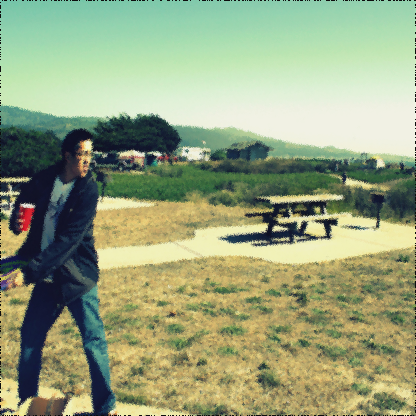

In [109]:
trans.ToPILImage()(de_preprocess(conf,imgs[b],cuda=True).cpu())

In [110]:
targets[0][b,1,8,1]

tensor([ 0.9375,  0.4688, -0.2707,  0.3712,  1.0000,  0.0000], device='cuda:0')

In [112]:
gt_mask[0][b,1,8,1]

tensor(0., device='cuda:0')

In [114]:
targets[2][b,2,26,35]

tensor([  0.3750,   0.6250,   0.8979,  -0.6506,   1.0000,  13.0000], device='cuda:0')

In [115]:
gt_mask[2][b,2,26,35]

tensor(1., device='cuda:0')

In [116]:
coord_mask[2][b,2,26,35]

tensor(0., device='cuda:0')

In [22]:
bboxes_group[b][:,:2][2]/16

tensor([  0.7500,  16.8125], device='cuda:0')

In [23]:
bboxes_group[b][:,:2][2]/16

tensor([  0.7500,  16.8125], device='cuda:0')

In [24]:
bboxes_group[b][:,2:][2]

tensor([ 24.,  33.], device='cuda:0')

In [25]:
model.head.anchors_group

[tensor([[ 116.,   90.],
         [ 156.,  198.],
         [ 373.,  326.]], device='cuda:0'), tensor([[  30.,   61.],
         [  62.,   45.],
         [  59.,  119.]], device='cuda:0'), tensor([[ 10.,  13.],
         [ 16.,  30.],
         [ 33.,  23.]], device='cuda:0')]

In [26]:
targets[0][b,0,4,8,:2]

tensor([ 0.,  0.], device='cuda:0')

In [27]:
targets[2][b,2,34,14,:2]

tensor([ 0.,  0.], device='cuda:0')